Notebook to train a fully convolutional network to detect nuclei and foci

## Imports

In [1]:
%matplotlib inline
from skimage import io
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from concurrent.futures import ProcessPoolExecutor

## Loading of training data

Number of training images: 34880


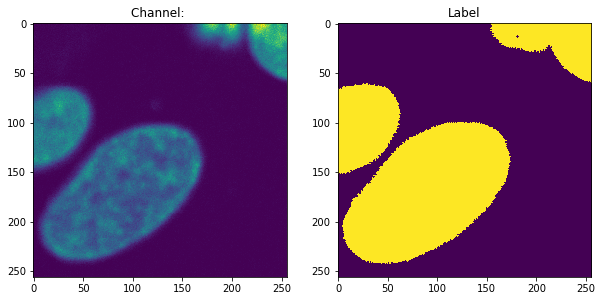

In [2]:
# Limit GPU Memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    
# Reproducibility
SEED = 32
# Define folders containing training data
nucdetect_folder = os.path.join(os.path.expanduser("~"), "NucDetect")
train_dir = os.path.join(nucdetect_folder, "train")
label_dir = os.path.join(nucdetect_folder, "labels")

train = []
label = []
# Load blue channel
for f in os.listdir(train_dir):
    if "Blue" in f:
        img = io.imread(os.path.join(train_dir, f))
        if img.shape == (1024, 1024):
            train.append(img[0:256, 0:256])
            train.append(img[0:256, 256:512])
            train.append(img[0:256, 512:768])
            train.append(img[0:256, 768:1024])
            train.append(img[256:512, 0:256])
            train.append(img[256:512, 256:512])
            train.append(img[256:512, 512:768])
            train.append(img[256:512, 768:1024])
            train.append(img[512:768, 0:256])
            train.append(img[512:768, 256:512])
            train.append(img[512:768, 512:768])
            train.append(img[512:768, 768:1024])
            train.append(img[768:1024, 0:256])
            train.append(img[768:1024, 256:512])
            train.append(img[768:1024, 512:768])
            train.append(img[768:1024, 768:1024])
            """
            train.append(img[0:512, 0:512])
            train.append(img[0:512, 512:1024])
            train.append(img[512:1024, 0:512])
            train.append(img[512:1024, 512:1024])
            """
            

# Load labels
for f in os.listdir(label_dir):
    if "Blue" in f:
        img = io.imread(os.path.join(label_dir, f))
        if img.shape == (1024, 1024):
            label.append(img[0:256, 0:256])
            label.append(img[0:256, 256:512])
            label.append(img[0:256, 512:768])
            label.append(img[0:256, 768:1024])
            label.append(img[256:512, 0:256])
            label.append(img[256:512, 256:512])
            label.append(img[256:512, 512:768])
            label.append(img[256:512, 768:1024])
            label.append(img[512:768, 0:256])
            label.append(img[512:768, 256:512])
            label.append(img[512:768, 512:768])
            label.append(img[512:768, 768:1024])
            label.append(img[768:1024, 0:256])
            label.append(img[768:1024, 256:512])
            label.append(img[768:1024, 512:768])
            label.append(img[768:1024, 768:1024])
            """
            label.append(img[0:512, 0:512])
            label.append(img[0:512, 512:1024])
            label.append(img[512:1024, 0:512])
            label.append(img[512:1024, 512:1024])
            """
            
train = np.asarray(train).astype("float32")
train /= 255
label = np.asarray(label).astype("float32")
label /= 255

print(f"Number of training images: {len(train)}")
# Show first image in train
fig, ax = plt.subplots(ncols=2, figsize=(10, 7.5))
ax[0].set_title(f"Channel: ")
ax[0].imshow(train[0])
ax[1].set_title("Label")
ax[1].imshow(label[0])
plt.show()

## Definition of FCN using Keras

In [3]:
# Unifom filter size for layers
kernel_size = (20, 20)
filters = 32
activation = "sigmoid"
act_output = "sigmoid"
# Define layers for the network
# Input block
inp = layers.Input((256, 256, 1))
c1 = layers.Conv2D(filters,
                   kernel_size=kernel_size,
                   activation=activation,
                   padding="same")(inp)
# 256x256
p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)
# Second block
c2 = layers.Conv2D(filters,
                   kernel_size=kernel_size,
                   activation=activation,
                   padding="same")(p1)
# 128x128
p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)
# Third block
c3 = layers.Conv2D(filters,
                   kernel_size=kernel_size,
                   activation=activation,
                   padding="same")(p2)
# 64x64
p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)
# Fourth block
c4 = layers.Conv2D(filters,
                   kernel_size=kernel_size,
                   activation=activation,
                   padding="same")(p3)
# 32x32
p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
# Add upsampling layers
# 64x64
u1 = layers.Conv2DTranspose(filters,
                            strides=2,
                            kernel_size=kernel_size,
                            activation=activation, 
                            padding="same")(p4)
# 128x128
u2 = layers.Conv2DTranspose(filters,
                            strides=2,
                            kernel_size=kernel_size,
                            activation=activation,
                            padding="same")(u1)
# Build the first skip connection
u2 = layers.concatenate([u2, c3])
# 256x256
u3 = layers.Conv2DTranspose(filters,
                            strides=2,
                            kernel_size=kernel_size,
                            activation=activation,
                            padding="same")(u2)
# Create second skip connection
u3 = layers.concatenate([u3, c2])
# 512x512
u4 = layers.Conv2DTranspose(filters,
                            strides=2,
                            kernel_size=kernel_size,
                            activation=activation,
                            padding="same")(u3)
# Create third skip connection
u4 = layers.concatenate([u4, c1])
out = layers.Conv2D(1, 1,
                   activation=act_output)(u4)
model = models.Model(inputs=inp, outputs=out)
# Compile the model for usage
model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 12832       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 409632      max_pooling2d[0][0]              
______________________________________________________________________________________________

Data shape: (34880, 256, 256, 1)
Label shape: (34880, 256, 256, 1)


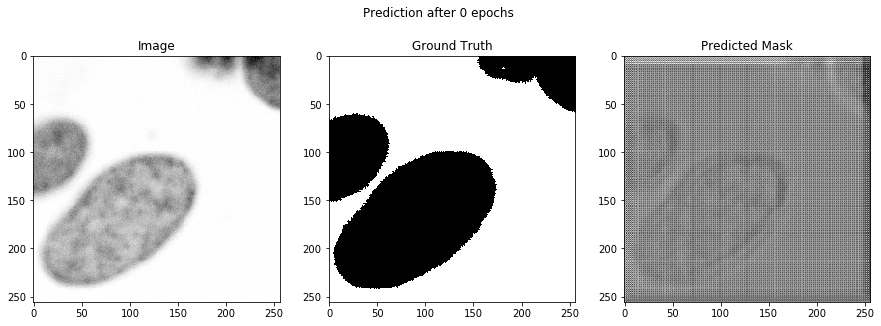

In [4]:
# Reshape data
train = train.reshape(-1, 256, 256, 1)
label = label.reshape(-1, 256, 256, 1)
print(f"Data shape: {train.shape}\nLabel shape: {label.shape}")

# Define function to create mask from model prediction
def create_mask(pred):
    # Get the whole output of the last layer
    mask = pred[0, :, :, 0]
    # Add a new axis to the prediction mask
    return mask[..., tf.newaxis]

# Define function to show predicted image
def show_prediction(epoch=0):
    # Get first train image
    img = train[0]
    lbl = label[0]
    # Create prediction mask for first image
    pred = create_mask(model.predict(img[tf.newaxis, ...]))
    # Create plot
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
    fig.suptitle(f"Prediction after {epoch} epochs")
    ax[0].imshow(tf.keras.preprocessing.image.array_to_img(img), cmap="binary")
    ax[0].set_title("Image")
    ax[1].imshow(tf.keras.preprocessing.image.array_to_img(lbl), cmap="binary")
    ax[1].set_title("Ground Truth")
    ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred), cmap="binary")
    ax[2].set_title("Predicted Mask")
    plt.show()

# Show prediction without training
show_prediction()

Train on 31392 samples, validate on 3488 samples
Epoch 1/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0573 - accuracy: 0.9840

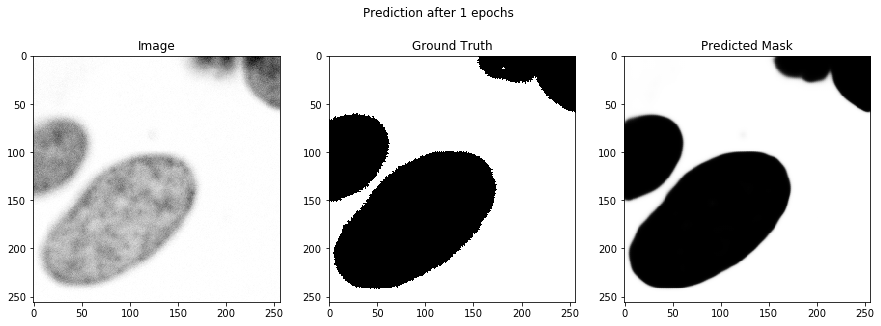

31392/31392 [==============================] - 27937s 890ms/sample - loss: 0.0573 - accuracy: 0.9840 - val_loss: 0.0187 - val_accuracy: 0.9935
Epoch 2/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0204 - accuracy: 0.9930

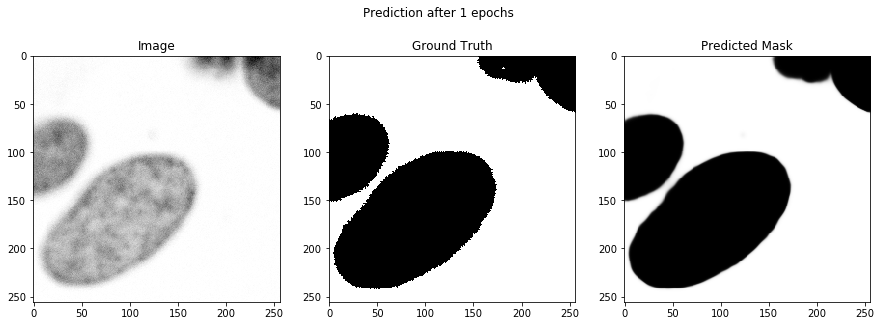

31392/31392 [==============================] - 27869s 888ms/sample - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.0139 - val_accuracy: 0.9951
Epoch 3/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0176 - accuracy: 0.9941

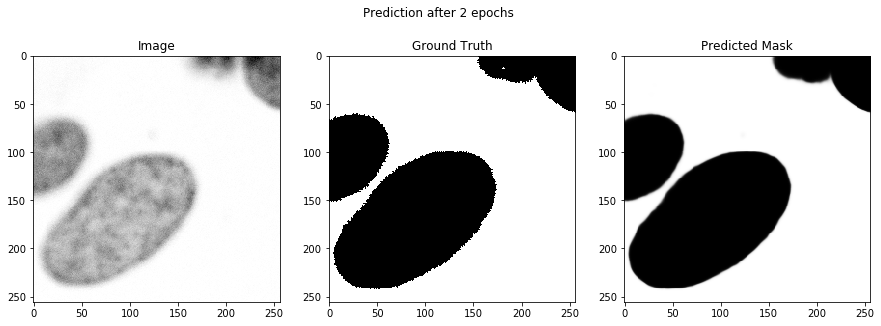

31392/31392 [==============================] - 27787s 885ms/sample - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.0119 - val_accuracy: 0.9959
Epoch 4/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0164 - accuracy: 0.9946

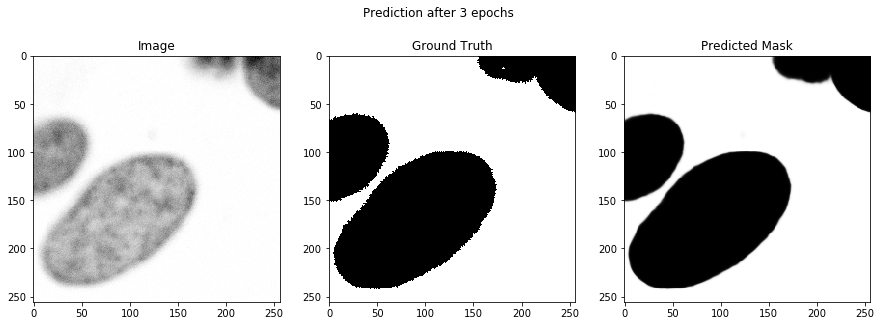

31392/31392 [==============================] - 27788s 885ms/sample - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.0111 - val_accuracy: 0.9962
Epoch 5/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0157 - accuracy: 0.9949

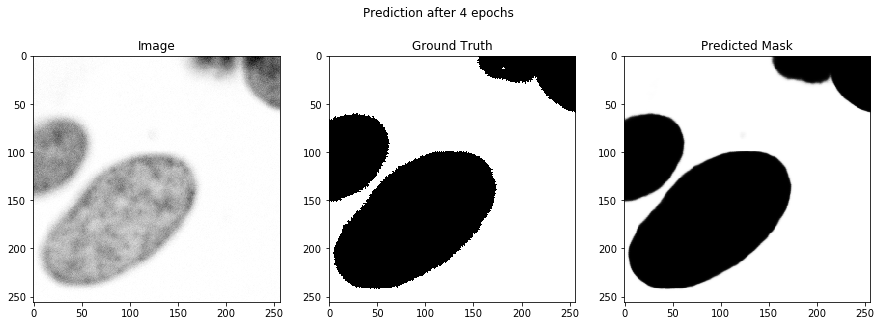

31392/31392 [==============================] - 27796s 885ms/sample - loss: 0.0157 - accuracy: 0.9949 - val_loss: 0.0110 - val_accuracy: 0.9962
Epoch 6/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0152 - accuracy: 0.9950

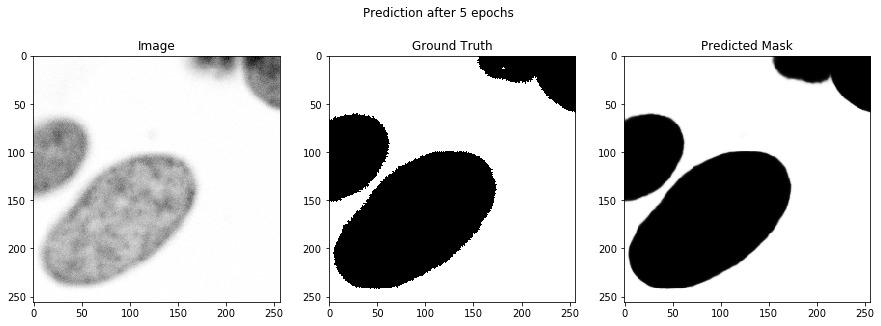

31392/31392 [==============================] - 27768s 885ms/sample - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0101 - val_accuracy: 0.9965
Epoch 7/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0149 - accuracy: 0.9951

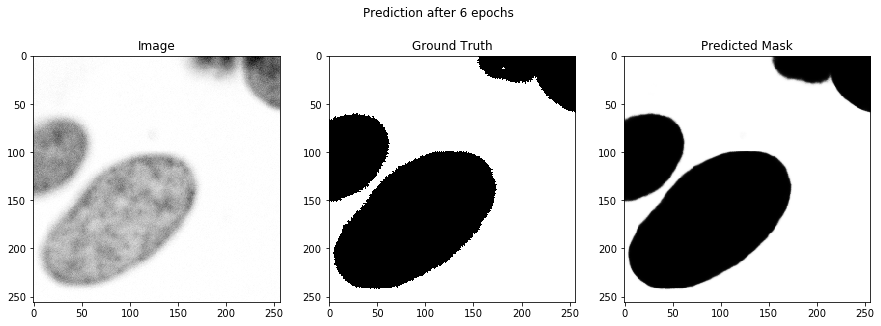

31392/31392 [==============================] - 27767s 885ms/sample - loss: 0.0149 - accuracy: 0.9951 - val_loss: 0.0099 - val_accuracy: 0.9964
Epoch 8/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0145 - accuracy: 0.9951

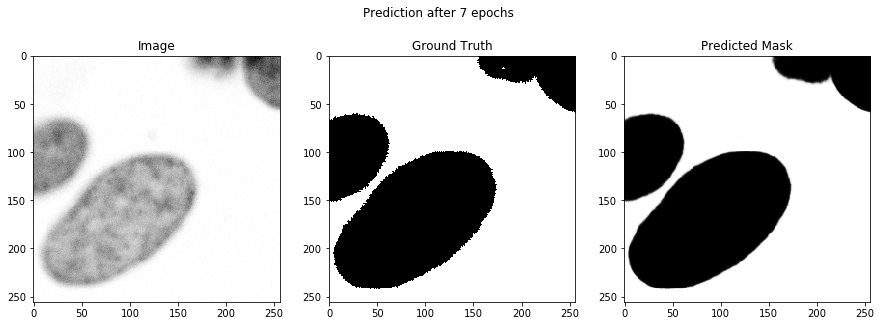

31392/31392 [==============================] - 27273s 869ms/sample - loss: 0.0145 - accuracy: 0.9951 - val_loss: 0.0094 - val_accuracy: 0.9966
Epoch 9/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0143 - accuracy: 0.9952

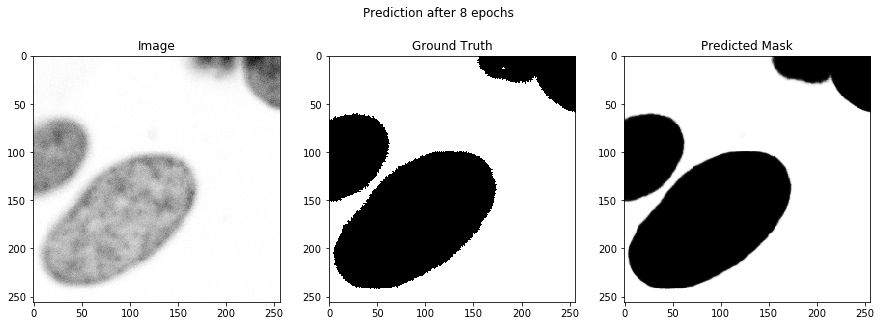

31392/31392 [==============================] - 27048s 862ms/sample - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0094 - val_accuracy: 0.9966
Epoch 10/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0140 - accuracy: 0.9953

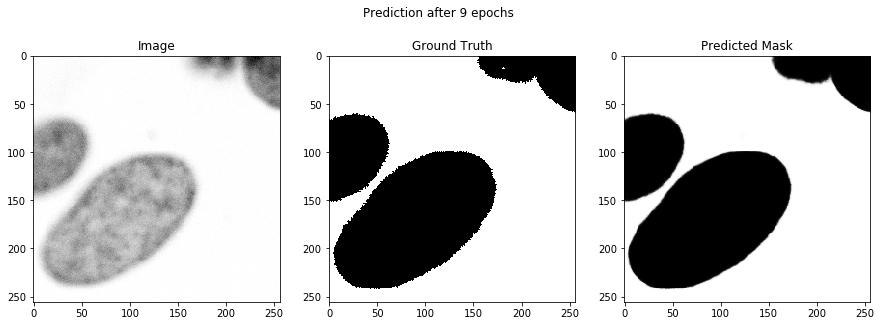

31392/31392 [==============================] - 27507s 876ms/sample - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.0093 - val_accuracy: 0.9966
Epoch 11/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0138 - accuracy: 0.9954

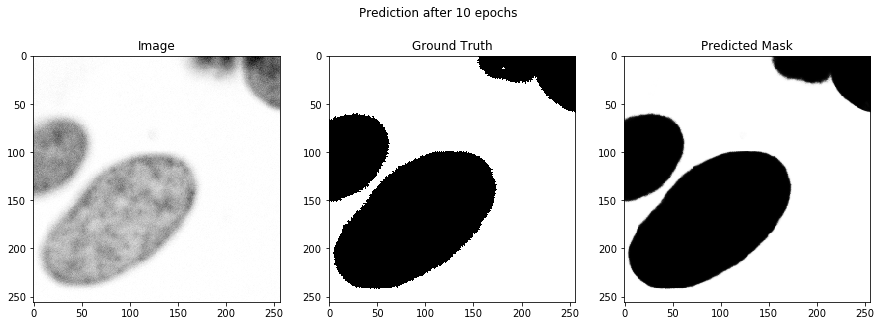

31392/31392 [==============================] - 27820s 886ms/sample - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.0089 - val_accuracy: 0.9967
Epoch 12/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0137 - accuracy: 0.9954

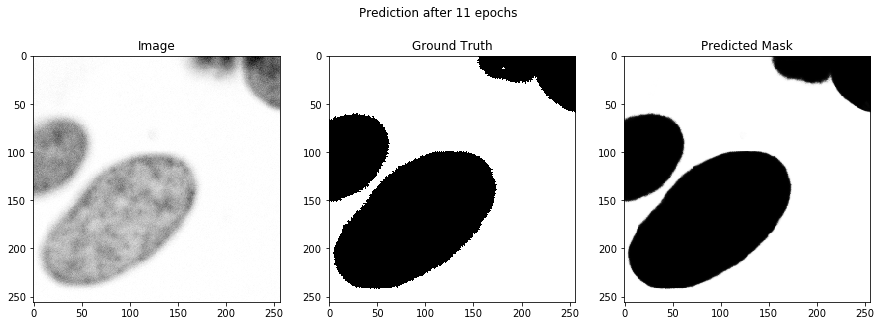

31392/31392 [==============================] - 27754s 884ms/sample - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.0087 - val_accuracy: 0.9969
Epoch 13/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0135 - accuracy: 0.9955

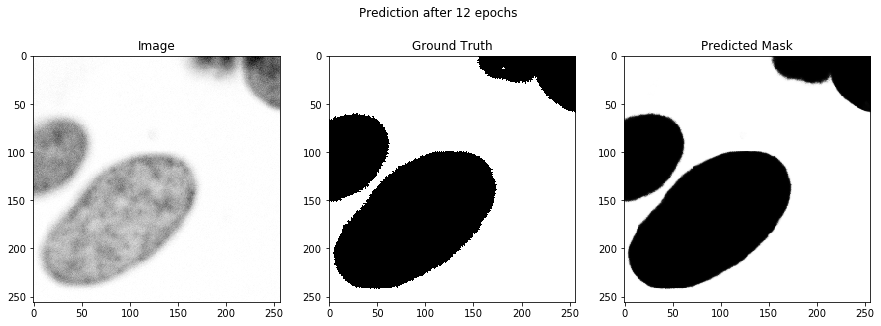

31392/31392 [==============================] - 27783s 885ms/sample - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.0086 - val_accuracy: 0.9969
Epoch 14/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0134 - accuracy: 0.9956

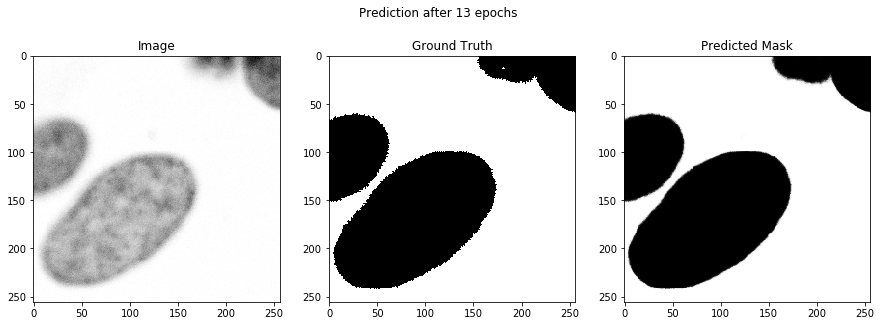

31392/31392 [==============================] - 27697s 882ms/sample - loss: 0.0134 - accuracy: 0.9956 - val_loss: 0.0084 - val_accuracy: 0.9970
Epoch 15/15
31376/31392 [============================>.] - ETA: 13s - loss: 0.0132 - accuracy: 0.9956

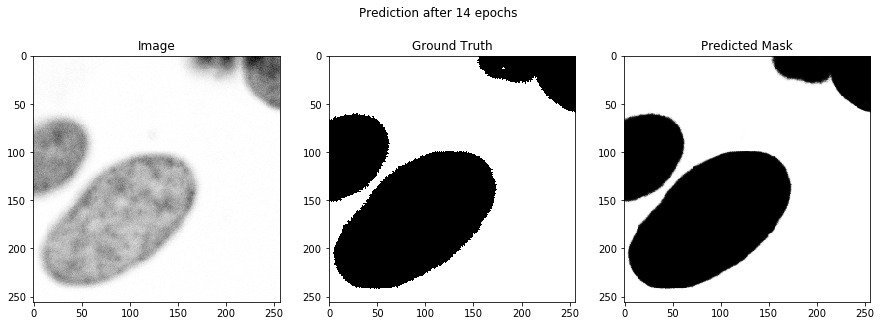

31392/31392 [==============================] - 27707s 883ms/sample - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.0082 - val_accuracy: 0.9971


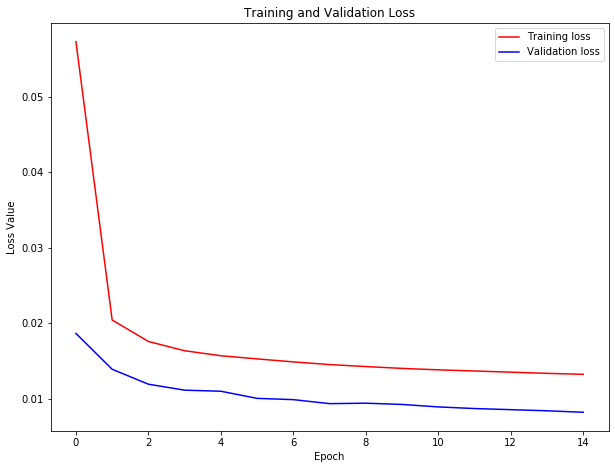

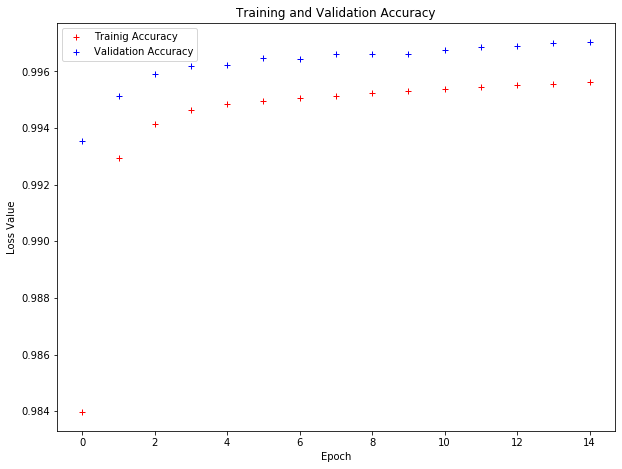

In [5]:
# Define Callback to use created functions
class ModelCallback(tf.keras.callbacks.Callback):
    """
    Callback to show predictions after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.acc = 0
        self.loss = 0
        
    def on_epoch_end(self, epochs, logs=None):
        self.epoch = epochs
        self.acc = logs["accuracy"]
        self.loss = logs["loss"]
        
    def on_test_end(self, logs=None):
        # Show the predicted mask
        pass
        #show_prediction(self.epoch+1)


# Define parameters for training
# Number of epochs
EPOCHS = 15
# Size of training batches
BATCH_SIZE = 16

# Stop training if validation accuracy is no longer increasing
earlystopper = EarlyStopping(patience=3, verbose=1)
#Train the model
history = model.fit(train,
                    label,
                    validation_split=0.1,
                    batch_size=BATCH_SIZE,
                    callbacks=[ModelCallback(), earlystopper],
                    epochs=EPOCHS,
)
# Save the model
SAVEDIR = r"C:/tf_models"
model.save(os.path.join(SAVEDIR, "nucleus_detector.h5"))

# Get training parameters
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
# Plot training parameters
epochs = range(len(loss))
plt.figure(figsize=(10, 7.5))
plt.title("Training and Validation Loss")
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()
plt.figure(figsize=(10, 7.5))
plt.title("Training and Validation Accuracy")
plt.plot(epochs, acc, 'r+', label="Trainig Accuracy")
plt.plot(epochs, val_acc, 'b+', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

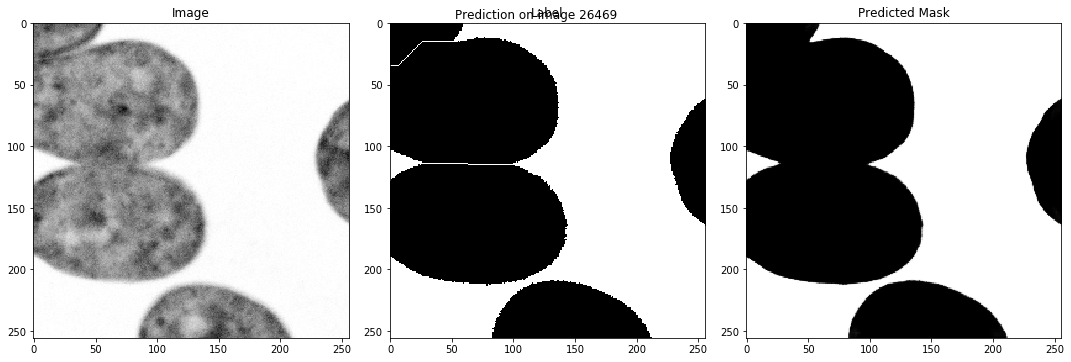

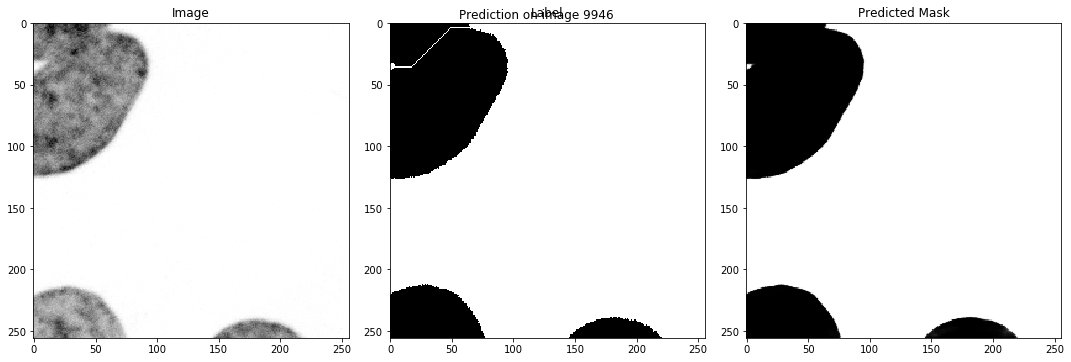

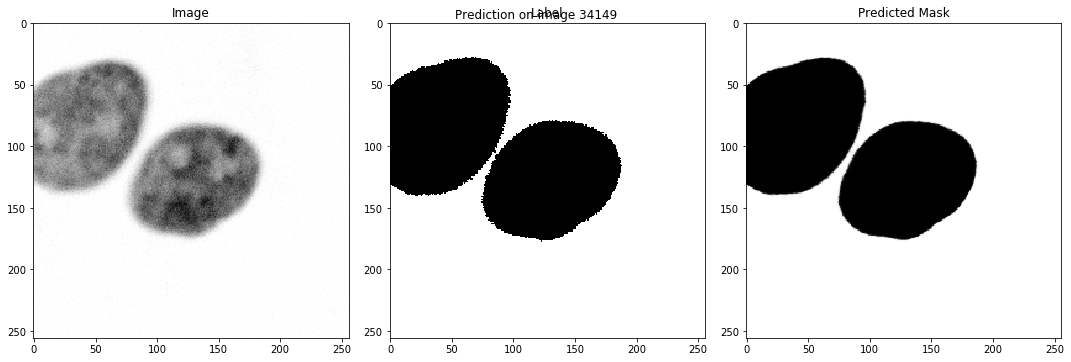

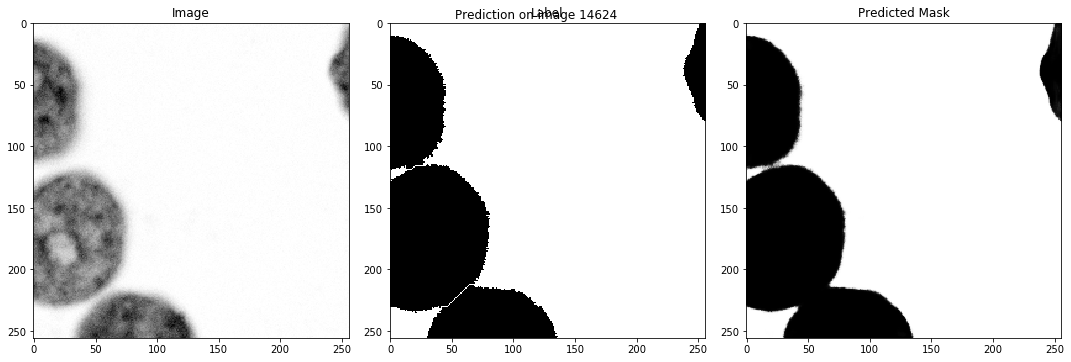

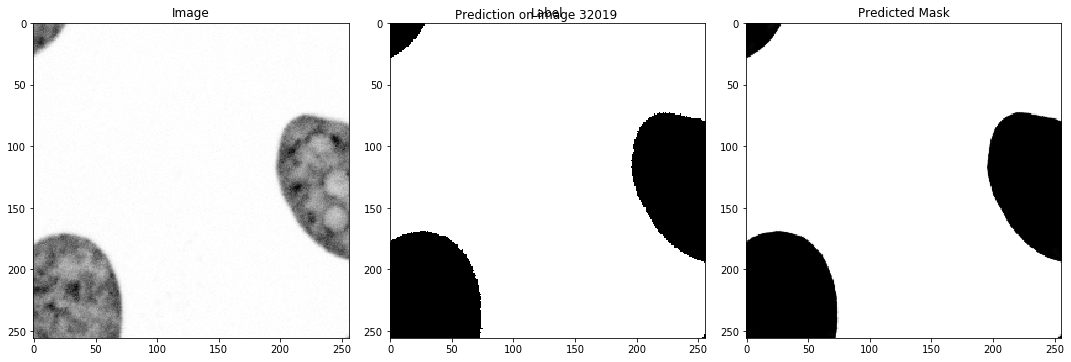

In [6]:
# Test on random images
import random

for _ in range(2):
    ind = random.randint(0, len(train))
    img = train[ind]
    lab = label[ind]
    # Create prediction mask for first image
    pred = create_mask(model.predict(img[tf.newaxis, ...]))
    # Create plot
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
    fig.suptitle(f"Prediction on image {ind}")
    ax[0].imshow(tf.keras.preprocessing.image.array_to_img(img), cmap="binary")
    ax[0].set_title("Image")
    ax[1].imshow(tf.keras.preprocessing.image.array_to_img(lab), cmap="binary")
    ax[1].set_title("Label")
    ax[2].imshow(tf.keras.preprocessing.image.array_to_img(pred), cmap="binary")
    ax[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()